# Installations

In [1]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q scann

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 90.7 MB/s eta 0:00:00


# Mount Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# append paths
import sys
sys.path.append('/content/drive/MyDrive/2023_movie_recommender/')

# Imports

In [3]:
import os
from datetime import datetime
import matplotlib.pyplot as plt

import pprint
import tempfile

import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

from models_v4 import RetrievalModel
from models_v4 import RankingModel

In [4]:
print(f'Tensorflow version: {tf.__version__}')
print(f'keras version: {keras.__version__}')
print(f'Tensorflow Recommenders version: {tfrs.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Tensorflow version: 2.11.0
keras version: 2.11.0
Tensorflow Recommenders version: v0.7.3
Numpy version: 1.21.6
Pandas version: 1.3.5


# TF Movielens-100k dataset: test current implementation by comparing the predictions with that from TFRS tutorial results

In [6]:
# Ratings data.
tf_ratings = tfds.load("movielens/100k-ratings", split="train")
# Features of all the available movies.
tf_movies = tfds.load("movielens/100k-movies", split="train")

tf_ratings = tf_ratings.map(lambda x: {
    "title": x["movie_title"],
    "userId": x["user_id"],
    "timestamp": x["timestamp"],
})
tf_movies = tf_movies.map(lambda x: x["movie_title"])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-ratings/0.1.1.incompleteM05FR3/movielens-train.tfrecord*...…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.1. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1682 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-movies/0.1.1.incompleteH8PHQV/movielens-train.tfrecord*...:…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-movies/0.1.1. Subsequent calls will reuse this data.


In [8]:
tf_timestamps = np.concatenate(list(tf_ratings.map(lambda x: x["timestamp"]).batch(100)))

tf.random.set_seed(42)
tf_shuffled = tf_ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

tf_train = tf_shuffled.take(80_000)
tf_test = tf_shuffled.skip(80_000).take(20_000)

tf_cached_train = tf_train.shuffle(100_000).batch(2048)
tf_cached_test = tf_test.batch(4096).cache()

In [9]:
debug = True
num_epochs = 120
embedding_size = 32
time_encode_size = 8
layer_sizes = [64]
max_num_users = 1_000
max_num_movies = 10_000
use_time = 'buckets'
use_gru = False
use_genres = False

model = RetrievalModel(tf_movies, tf_timestamps, tf_movies, 
                       use_time=use_time, 
                       use_gru=use_gru, 
                       use_genres=use_genres,
                       embedding_size=embedding_size, 
                       time_encode_size=time_encode_size,
                       layer_sizes=layer_sizes,
                       max_num_users=max_num_users, 
                       debug=debug,
                       max_num_movies=max_num_movies
                       )

model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

history_base = model.fit(
    tf_cached_train,
    validation_data=tf_cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=1,
)
    

Epoch 1/120
40/40 [==============================] - 21s 328ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 14936.3535 - regularization_loss: 0.0000e+00 - total_loss: 14936.3535
Epoch 2/120
40/40 [==============================] - 9s 126ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 14434.3193 - regularization_loss: 0.0000e+00 - total_loss: 14434.3193
Epoch 3/120
40/40 [==============================] - 7s 128ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e

# Data preprocessing

In [5]:
# read data
dataset = '/content/drive/MyDrive/2023_movie_recommender/datasets/ml-latest-small'
movies = pd.read_csv(os.path.join(dataset, 'movies.csv'))
ratings = pd.read_csv(os.path.join(dataset, 'ratings.csv'))

In [6]:
# view movies dataframe
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
# view ratings dataframe
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
# filter out rarely rated movies and rarely rating users
min_movie_ratings = 20
#min_user_ratings = 20

filter_movies = (ratings['movieId'].value_counts() > min_movie_ratings)
filter_movies = filter_movies[filter_movies].index.tolist()

#filter_users = (ratings['userId'].value_counts() > min_user_ratings)
#filter_users = filter_users[filter_users].index.tolist()

# get filtered data
#mask = (ratings['movieId'].isin(filter_movies)) & (ratings['userId'].isin(filter_users))
mask = (ratings['movieId'].isin(filter_movies))
print(f'Before filtering, Ratings size: {ratings.shape}')
ratings = ratings[mask]
#del filter_movies, filter_users
del filter_movies
print(f'After filtering, Ratings size: {ratings.shape}')
ratings.head()

Before filtering, Ratings size: (100836, 4)
After filtering, Ratings size: (66658, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [9]:
# convert timestamp to datetime
ratings['datetime'] = ratings['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
ratings.head()

,userId,movieId,rating,timestamp,datetime
0,1,1,4.0,964982703,2000-07-30 18:45:03
1,1,3,4.0,964981247,2000-07-30 18:20:47
2,1,6,4.0,964982224,2000-07-30 18:37:04
3,1,47,5.0,964983815,2000-07-30 19:03:35
4,1,50,5.0,964982931,2000-07-30 18:48:51


In [10]:
# extract month, day and hour
ratings['year'] = ratings.datetime.dt.year
ratings['month'] = ratings.datetime.dt.month
ratings['weekday'] = ratings['datetime'].apply(lambda x: x.weekday())
ratings['day'] = ratings.datetime.dt.day
ratings['hour'] = ratings.datetime.dt.hour
ratings.head()

,userId,movieId,rating,timestamp,datetime,year,month,weekday,day,hour
0,1,1,4.0,964982703,2000-07-30 18:45:03,2000,7,6,30,18
1,1,3,4.0,964981247,2000-07-30 18:20:47,2000,7,6,30,18
2,1,6,4.0,964982224,2000-07-30 18:37:04,2000,7,6,30,18
3,1,47,5.0,964983815,2000-07-30 19:03:35,2000,7,6,30,19
4,1,50,5.0,964982931,2000-07-30 18:48:51,2000,7,6,30,18


In [11]:
## encode month, day, hour
#def encode(df, col, max_val):
#    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
#    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
#    return df
#
#ratings = encode(ratings, 'month', 12)
#ratings = encode(ratings, 'weekday', 7)
#ratings = encode(ratings, 'day', 31)
#ratings = encode(ratings, 'hour', 24)
#
#ratings.head()

In [12]:
# remove pipes in genres
movies['genres'] = movies.genres.str.replace('(\|)', ' ')
movies.head()

<ipython-input-12-6a169495a1b4>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  movies['genres'] = movies.genres.str.replace('(\|)', ' ')


,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [13]:
# left join ratings with movies
ratings = ratings.join(movies.set_index('movieId'), on='movieId', how='left')
ratings.head()

,userId,movieId,rating,timestamp,datetime,year,month,weekday,day,hour,title,genres
0,1,1,4.0,964982703,2000-07-30 18:45:03,2000,7,6,30,18,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,1,3,4.0,964981247,2000-07-30 18:20:47,2000,7,6,30,18,Grumpier Old Men (1995),Comedy Romance
2,1,6,4.0,964982224,2000-07-30 18:37:04,2000,7,6,30,18,Heat (1995),Action Crime Thriller
3,1,47,5.0,964983815,2000-07-30 19:03:35,2000,7,6,30,19,Seven (a.k.a. Se7en) (1995),Mystery Thriller
4,1,50,5.0,964982931,2000-07-30 18:48:51,2000,7,6,30,18,"Usual Suspects, The (1995)",Crime Mystery Thriller


In [14]:
# drop rows in ratings that don't have genres and years
print(f'Before droping: {ratings.shape}')
ratings = ratings[~ratings['genres'].isna()]
print(f'After droping: {ratings.shape}')

Before droping: (66658, 12)
After droping: (66658, 12)


In [15]:
# drop movies that don't have genres 
print(f'Before droping: {movies.shape}')
movies = movies[~movies['genres'].isna()]
print(f'After droping: {movies.shape}')
movies.describe()

Before droping: (9742, 3)
After droping: (9742, 3)


,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


In [16]:
# drop unneeded columns
ratings.drop(['datetime'], axis=1, inplace=True)
ratings.head()

,userId,movieId,rating,timestamp,year,month,weekday,day,hour,title,genres
0,1,1,4.0,964982703,2000,7,6,30,18,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,1,3,4.0,964981247,2000,7,6,30,18,Grumpier Old Men (1995),Comedy Romance
2,1,6,4.0,964982224,2000,7,6,30,18,Heat (1995),Action Crime Thriller
3,1,47,5.0,964983815,2000,7,6,30,19,Seven (a.k.a. Se7en) (1995),Mystery Thriller
4,1,50,5.0,964982931,2000,7,6,30,18,"Usual Suspects, The (1995)",Crime Mystery Thriller


In [17]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66658 entries, 0 to 100834
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     66658 non-null  int64  
 1   movieId    66658 non-null  int64  
 2   rating     66658 non-null  float64
 3   timestamp  66658 non-null  int64  
 4   year       66658 non-null  int64  
 5   month      66658 non-null  int64  
 6   weekday    66658 non-null  int64  
 7   day        66658 non-null  int64  
 8   hour       66658 non-null  int64  
 9   title      66658 non-null  object 
 10  genres     66658 non-null  object 
dtypes: float64(1), int64(8), object(2)
memory usage: 6.1+ MB


In [18]:
# need to convert month, weekday, day, hour into float64
ratings['month'] = ratings['month'].astype(float)
ratings['weekday'] = ratings['weekday'].astype(float)
ratings['day'] = ratings['day'].astype(float)
ratings['hour'] = ratings['hour'].astype(float)

In [19]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66658 entries, 0 to 100834
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     66658 non-null  int64  
 1   movieId    66658 non-null  int64  
 2   rating     66658 non-null  float64
 3   timestamp  66658 non-null  int64  
 4   year       66658 non-null  int64  
 5   month      66658 non-null  float64
 6   weekday    66658 non-null  float64
 7   day        66658 non-null  float64
 8   hour       66658 non-null  float64
 9   title      66658 non-null  object 
 10  genres     66658 non-null  object 
dtypes: float64(5), int64(4), object(2)
memory usage: 6.1+ MB


In [20]:
# convert into Tensorflow Dataset
movies_tf = tf.data.Dataset.from_tensor_slices(dict(movies))
ratings_tf = tf.data.Dataset.from_tensor_slices(dict(ratings))

# test if the loading is correct
for x in ratings_tf.take(1).as_numpy_iterator():
    pprint.pprint(x)

for x in movies_tf.take(1).as_numpy_iterator():
    pprint.pprint(x)


{'day': 30.0,
 'genres': b'Adventure Animation Children Comedy Fantasy',
 'hour': 18.0,
 'month': 7.0,
 'movieId': 1,
 'rating': 4.0,
 'timestamp': 964982703,
 'title': b'Toy Story (1995)',
 'userId': 1,
 'weekday': 6.0,
 'year': 2000}
{'genres': b'Adventure Animation Children Comedy Fantasy',
 'movieId': 1,
 'title': b'Toy Story (1995)'}


In [21]:
# check unique movie titles and user ids
movies_tmp = movies_tf.map(lambda x: x['title'])
movie_titles = movies_tmp.batch(1_000)
user_ids = ratings_tf.batch(10_000).map(lambda x: x['userId'])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

print(unique_movie_titles.shape)
print(unique_user_ids.shape)

(9737,)
(610,)


In [22]:
# split into train and test datasets
# total = 101_000
# ntrain = 81_000
# ntest = 20_000

total = 67_000
ntrain = 60_000
ntest = 7_000
tf.random.set_seed(42)
shuffled = ratings_tf.shuffle(total, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(ntrain)
test = shuffled.skip(ntrain).take(ntest)

cached_train = train.shuffle(ntrain).batch(2048)
cached_test = test.batch(4096).cache()

In [23]:
for x in cached_test.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'day': array([ 9.,  8., 12., ..., 24.,  5.,  2.]),
 'genres': array([b'Comedy Drama Romance', b'Action Adventure Comedy Romance',
       b'Children Comedy Fantasy', ..., b'Action Comedy Western',
       b'Adventure Fantasy Thriller IMAX', b'Adventure Children Fantasy'],
      dtype=object),
 'hour': array([ 8., 13., 14., ...,  2., 12., 15.]),
 'month': array([ 7.,  6.,  7., ..., 12.,  9.,  6.]),
 'movieId': array([ 1784,   552,  6936, ...,  1378, 40815,  4896]),
 'rating': array([4. , 2. , 4. , ..., 2.5, 3.5, 3.5]),
 'timestamp': array([1468051563,  834241987, 1215872303, ..., 1261623539, 1346847838,
       1054568482]),
 'title': array([b'As Good as It Gets (1997)', b'Three Musketeers, The (1993)',
       b'Elf (2003)', ..., b'Young Guns (1988)',
       b'Harry Potter and the Goblet of Fire (2005)',
       b"Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)"],
      dtype=object),
 'userId': array([ 52, 314, 483, ...,  68, 249, 288]),
 'we

In [24]:
num_epochs = 120
timestamps = np.concatenate(list(ratings_tf.map(lambda x: x['timestamp']).batch(100)))
candidate_movies = movies_tf.map(lambda x: {
    'title': x['title'], 
    'genres': x['genres'],
    })


# Ml-latest-small dataset: keep the same hyperparameters to see how dataset influences prediction results

In [77]:
# use buckets
emb_size = 32
time_encode_size = 8
layer_sizes = [64]
max_num_users = 1_000
max_num_movies = 10_000
use_time = 'buckets'
use_gru = False
use_genres = False
debug = False

model = RetrievalModel(candidate_movies, timestamps, movies,
                       use_time=use_time, 
                       use_gru=use_gru, 
                       use_genres=use_genres,
                       embedding_size=emb_size, 
                       time_encode_size=time_encode_size,
                       layer_sizes=layer_sizes,
                       max_num_users=max_num_users, 
                       debug=debug,
                       max_num_movies=max_num_movies
                       )

model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

history_buckets = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=1,
    )

Epoch 1/120
30/30 [==============================] - 9s 223ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 16539.5547 - regularization_loss: 0.0000e+00 - total_loss: 16539.5547
Epoch 2/120
30/30 [==============================] - 5s 143ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 14412.3513 - regularization_loss: 0.0000e+00 - total_loss: 14412.3513
Epoch 3/120
30/30 [==============================] - 3s 99ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+0

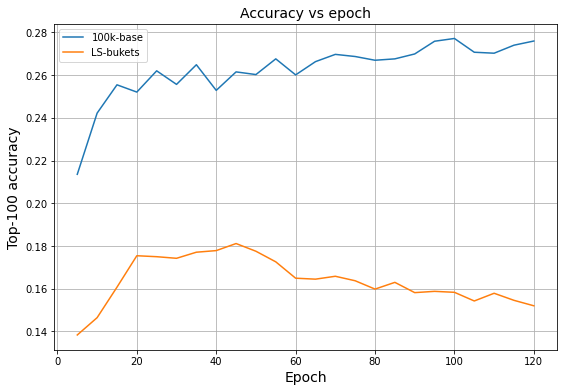

In [78]:
# plot and compare
num_validation_runs = len(history_base.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.figure(figsize=(9,6))
fs = 14
plt.plot(epochs, history_base.history["val_factorized_top_k/top_100_categorical_accuracy"], label='100k-base')
plt.plot(epochs, history_buckets.history["val_factorized_top_k/top_100_categorical_accuracy"], label='LS-bukets')
plt.title("Accuracy vs epoch", fontsize=fs)
plt.xlabel("Epoch", fontsize=fs)
plt.ylabel("Top-100 accuracy", fontsize=fs);
plt.grid()
plt.legend()
plt.show()

# Ml-latest-small dataset: keep the same hyperparameters to see how dataset influences prediction results - try smaller model

In [79]:
# use buckets
emb_size = 16
time_encode_size = 8
layer_sizes = [32]
max_num_users = 1_000
max_num_movies = 10_000
use_time = 'buckets'
use_gru = False
use_genres = False
debug = False

model = RetrievalModel(candidate_movies, timestamps, movies,
                       use_time=use_time, 
                       use_gru=use_gru, 
                       use_genres=use_genres,
                       embedding_size=emb_size, 
                       time_encode_size=time_encode_size,
                       layer_sizes=layer_sizes,
                       max_num_users=max_num_users, 
                       debug=debug,
                       max_num_movies=max_num_movies
                       )

model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

history_buckets_small = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=1,
    )

Epoch 1/120
30/30 [==============================] - 14s 385ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 14786.5161 - regularization_loss: 0.0000e+00 - total_loss: 14786.5161
Epoch 2/120
30/30 [==============================] - 6s 170ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 14233.6955 - regularization_loss: 0.0000e+00 - total_loss: 14233.6955
Epoch 3/120
30/30 [==============================] - 6s 172ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e

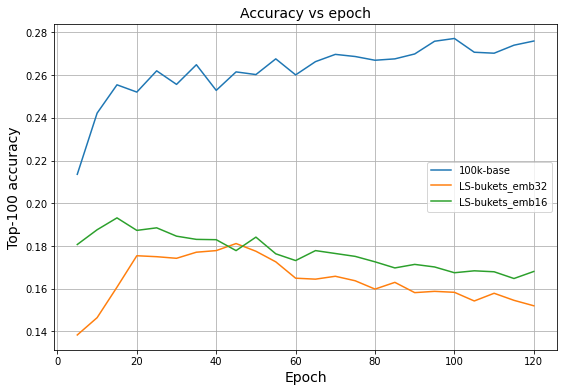

In [89]:
# plot and compare
num_validation_runs = len(history_base.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.figure(figsize=(9,6))
fs = 14
plt.plot(epochs, history_base.history["val_factorized_top_k/top_100_categorical_accuracy"], label='100k-base')
plt.plot(epochs, history_buckets.history["val_factorized_top_k/top_100_categorical_accuracy"], label='LS-bukets_emb32')
plt.plot(epochs, history_buckets_small.history["val_factorized_top_k/top_100_categorical_accuracy"], label='LS-bukets_emb16')
plt.title("Accuracy vs epoch", fontsize=fs)
plt.xlabel("Epoch", fontsize=fs)
plt.ylabel("Top-100 accuracy", fontsize=fs);
plt.grid()
plt.legend()
plt.show()

# Lastest-small dataset: using Sine-Cosine encoder - 16

In [86]:
# use buckets
emb_size = 16
time_encode_size = 16
layer_sizes = [64]
max_num_users = 1_000
max_num_movies = 10_000
use_time = 'sc_encoder'
use_gru = False
use_genres = False
debug = False

model = RetrievalModel(candidate_movies, timestamps, movies,
                       use_time=use_time, 
                       use_gru=use_gru, 
                       use_genres=use_genres,
                       embedding_size=emb_size, 
                       time_encode_size=time_encode_size,
                       layer_sizes=layer_sizes,
                       max_num_users=max_num_users, 
                       debug=debug,
                       max_num_movies=max_num_movies
                       )

model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

history_SCencoder16 = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=1,
    )

Epoch 1/120
30/30 [==============================] - 9s 174ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 14796.5275 - regularization_loss: 0.0000e+00 - total_loss: 14796.5275
Epoch 2/120
30/30 [==============================] - 4s 109ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 14408.2928 - regularization_loss: 0.0000e+00 - total_loss: 14408.2928
Epoch 3/120
30/30 [==============================] - 5s 132ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+

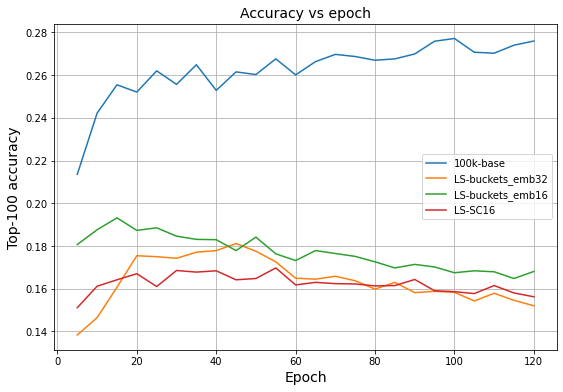

In [90]:
# plot and compare
#num_validation_runs = len(history_base.history["val_factorized_top_k/top_100_categorical_accuracy"])
#epochs = [(x + 1)* 5 for x in range(num_validation_runs)]
epochs = list(np.arange(5, 125, 5))

plt.figure(figsize=(9,6))
fs = 14
plt.plot(epochs, history_base.history["val_factorized_top_k/top_100_categorical_accuracy"], label='100k-base')
plt.plot(epochs, history_buckets.history["val_factorized_top_k/top_100_categorical_accuracy"], label='LS-buckets_emb32')
plt.plot(epochs, history_buckets_small.history["val_factorized_top_k/top_100_categorical_accuracy"], label='LS-buckets_emb16')
plt.plot(epochs, history_SCencoder16.history["val_factorized_top_k/top_100_categorical_accuracy"], label='LS-SC16')
plt.title("Accuracy vs epoch", fontsize=fs)
plt.xlabel("Epoch", fontsize=fs)
plt.ylabel("Top-100 accuracy", fontsize=fs);
plt.grid()
plt.legend()
plt.show()

# Lastest-small dataset: using Sine-Cosine encoder - 32

In [91]:
# use buckets
emb_size = 32
time_encode_size = 32
layer_sizes = [64]
max_num_users = 1_000
max_num_movies = 10_000
use_time = 'sc_encoder'
use_gru = False
use_genres = False
debug = False

model = RetrievalModel(candidate_movies, timestamps, movies,
                       use_time=use_time, 
                       use_gru=use_gru, 
                       use_genres=use_genres,
                       embedding_size=emb_size, 
                       time_encode_size=time_encode_size,
                       layer_sizes=layer_sizes,
                       max_num_users=max_num_users, 
                       debug=debug,
                       max_num_movies=max_num_movies
                       )

model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

history_SCencoder32 = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=1,
    )

Epoch 1/120
30/30 [==============================] - 11s 237ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 15882.7247 - regularization_loss: 0.0000e+00 - total_loss: 15882.7247
Epoch 2/120
30/30 [==============================] - 4s 130ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 14464.1094 - regularization_loss: 0.0000e+00 - total_loss: 14464.1094
Epoch 3/120
30/30 [==============================] - 8s 189ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e

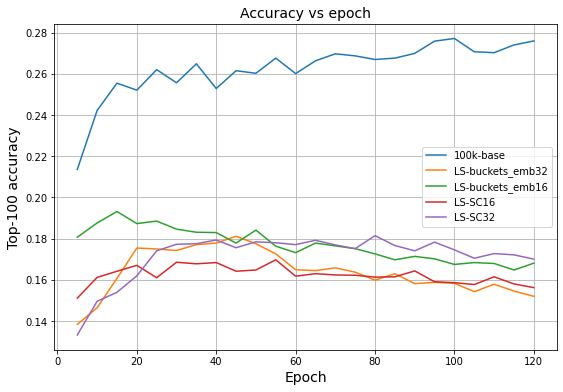

In [92]:
# plot and compare
#num_validation_runs = len(history_base.history["val_factorized_top_k/top_100_categorical_accuracy"])
#epochs = [(x + 1)* 5 for x in range(num_validation_runs)]
epochs = list(np.arange(5, 125, 5))

plt.figure(figsize=(9,6))
fs = 14
plt.plot(epochs, history_base.history["val_factorized_top_k/top_100_categorical_accuracy"], label='100k-base')
plt.plot(epochs, history_buckets.history["val_factorized_top_k/top_100_categorical_accuracy"], label='LS-buckets_emb32')
plt.plot(epochs, history_buckets_small.history["val_factorized_top_k/top_100_categorical_accuracy"], label='LS-buckets_emb16')
plt.plot(epochs, history_SCencoder16.history["val_factorized_top_k/top_100_categorical_accuracy"], label='LS-SC16')
plt.plot(epochs, history_SCencoder32.history["val_factorized_top_k/top_100_categorical_accuracy"], label='LS-SC32')
plt.title("Accuracy vs epoch", fontsize=fs)
plt.xlabel("Epoch", fontsize=fs)
plt.ylabel("Top-100 accuracy", fontsize=fs);
plt.grid()
plt.legend()
plt.show()

# Lastest-small dataset: discretized timestamp embedding + Sine-Cosine encoder

In [93]:
# use buckets
emb_size = 32
time_encode_size = 32
layer_sizes = [64]
max_num_users = 1_000
max_num_movies = 10_000
use_time = 'both'
use_gru = False
use_genres = False
debug = False

model = RetrievalModel(candidate_movies, timestamps, movies,
                       use_time=use_time, 
                       use_gru=use_gru, 
                       use_genres=use_genres,
                       embedding_size=emb_size, 
                       time_encode_size=time_encode_size,
                       layer_sizes=layer_sizes,
                       max_num_users=max_num_users, 
                       debug=debug,
                       max_num_movies=max_num_movies
                       )

model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

history_both = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=1,
    )

Epoch 1/120
30/30 [==============================] - 10s 225ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 16215.1417 - regularization_loss: 0.0000e+00 - total_loss: 16215.1417
Epoch 2/120
30/30 [==============================] - 6s 161ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 14425.9767 - regularization_loss: 0.0000e+00 - total_loss: 14425.9767
Epoch 3/120
30/30 [==============================] - 3s 94ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+

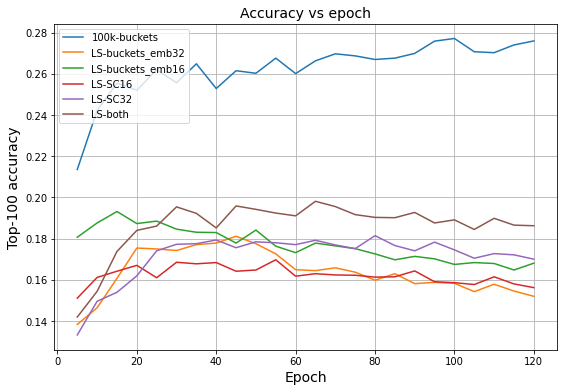

In [94]:
# plot and compare
#num_validation_runs = len(history_base.history["val_factorized_top_k/top_100_categorical_accuracy"])
#epochs = [(x + 1)* 5 for x in range(num_validation_runs)]
epochs = list(np.arange(5, 125, 5))

plt.figure(figsize=(9,6))
fs = 14
plt.plot(epochs, history_base.history["val_factorized_top_k/top_100_categorical_accuracy"], label='100k-buckets')
plt.plot(epochs, history_buckets.history["val_factorized_top_k/top_100_categorical_accuracy"], label='LS-buckets_emb32')
plt.plot(epochs, history_buckets_small.history["val_factorized_top_k/top_100_categorical_accuracy"], label='LS-buckets_emb16')
plt.plot(epochs, history_SCencoder16.history["val_factorized_top_k/top_100_categorical_accuracy"], label='LS-SC16')
plt.plot(epochs, history_SCencoder32.history["val_factorized_top_k/top_100_categorical_accuracy"], label='LS-SC32')
plt.plot(epochs, history_both.history["val_factorized_top_k/top_100_categorical_accuracy"], label='LS-both')
plt.title("Accuracy vs epoch", fontsize=fs)
plt.xlabel("Epoch", fontsize=fs)
plt.ylabel("Top-100 accuracy", fontsize=fs);
plt.grid()
plt.legend()
plt.show()

# Lastest-small dataset: discretized timestamp embedding + Sine-Cosine encoder + using genres

In [97]:
# use buckets
emb_size = 16
time_encode_size = 16
layer_sizes = [128, 32]
max_num_users = 1_000
max_num_movies = 10_000
use_time = 'both'
use_gru = False
use_genres = True
debug = False

model = RetrievalModel(candidate_movies, timestamps, movies,
                       use_time=use_time, 
                       use_gru=use_gru, 
                       use_genres=use_genres,
                       embedding_size=emb_size, 
                       time_encode_size=time_encode_size,
                       layer_sizes=layer_sizes,
                       max_num_users=max_num_users, 
                       debug=debug,
                       max_num_movies=max_num_movies
                       )

model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

history_both_genres = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=1,
    )

Epoch 1/120
30/30 [==============================] - 11s 226ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 15571.9926 - regularization_loss: 0.0000e+00 - total_loss: 15571.9926
Epoch 2/120
30/30 [==============================] - 6s 176ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 14690.6930 - regularization_loss: 0.0000e+00 - total_loss: 14690.6930
Epoch 3/120
30/30 [==============================] - 4s 131ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e

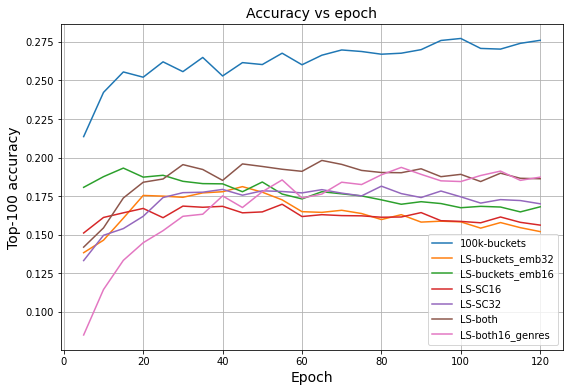

In [98]:
epochs = list(np.arange(5, 125, 5))

plt.figure(figsize=(9,6))
fs = 14
plt.plot(epochs, history_base.history["val_factorized_top_k/top_100_categorical_accuracy"], label='100k-buckets')
plt.plot(epochs, history_buckets.history["val_factorized_top_k/top_100_categorical_accuracy"], label='LS-buckets_emb32')
plt.plot(epochs, history_buckets_small.history["val_factorized_top_k/top_100_categorical_accuracy"], label='LS-buckets_emb16')
plt.plot(epochs, history_SCencoder16.history["val_factorized_top_k/top_100_categorical_accuracy"], label='LS-SC16')
plt.plot(epochs, history_SCencoder32.history["val_factorized_top_k/top_100_categorical_accuracy"], label='LS-SC32')
plt.plot(epochs, history_both.history["val_factorized_top_k/top_100_categorical_accuracy"], label='LS-both')
plt.plot(epochs, history_both_genres.history["val_factorized_top_k/top_100_categorical_accuracy"], label='LS-both16_genres')
plt.title("Accuracy vs epoch", fontsize=fs)
plt.xlabel("Epoch", fontsize=fs)
plt.ylabel("Top-100 accuracy", fontsize=fs);
plt.grid()
plt.legend()
plt.show()

# Lastest-small dataset: discretized timestamp embedding + Sine-Cosine encoder + using genres

In [100]:
# use buckets
emb_size = 32
time_encode_size = 32
layer_sizes = [128, 32]
max_num_users = 1_000
max_num_movies = 10_000
use_time = 'both'
use_gru = False
use_genres = True
debug = False

model = RetrievalModel(candidate_movies, timestamps, movies,
                       use_time=use_time, 
                       use_gru=use_gru, 
                       use_genres=use_genres,
                       embedding_size=emb_size, 
                       time_encode_size=time_encode_size,
                       layer_sizes=layer_sizes,
                       max_num_users=max_num_users, 
                       debug=debug,
                       max_num_movies=max_num_movies
                       )

model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

history_both32_genres = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=1,
    )

Epoch 1/120
30/30 [==============================] - 15s 293ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 19095.4160 - regularization_loss: 0.0000e+00 - total_loss: 19095.4160
Epoch 2/120
30/30 [==============================] - 7s 202ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 14723.8971 - regularization_loss: 0.0000e+00 - total_loss: 14723.8971
Epoch 3/120
30/30 [==============================] - 4s 102ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e

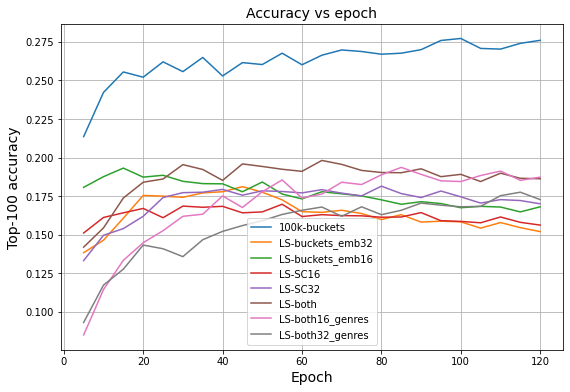

In [101]:
epochs = list(np.arange(5, 125, 5))

plt.figure(figsize=(9,6))
fs = 14
plt.plot(epochs, history_base.history["val_factorized_top_k/top_100_categorical_accuracy"], label='100k-buckets')
plt.plot(epochs, history_buckets.history["val_factorized_top_k/top_100_categorical_accuracy"], label='LS-buckets_emb32')
plt.plot(epochs, history_buckets_small.history["val_factorized_top_k/top_100_categorical_accuracy"], label='LS-buckets_emb16')
plt.plot(epochs, history_SCencoder16.history["val_factorized_top_k/top_100_categorical_accuracy"], label='LS-SC16')
plt.plot(epochs, history_SCencoder32.history["val_factorized_top_k/top_100_categorical_accuracy"], label='LS-SC32')
plt.plot(epochs, history_both.history["val_factorized_top_k/top_100_categorical_accuracy"], label='LS-both')
plt.plot(epochs, history_both_genres.history["val_factorized_top_k/top_100_categorical_accuracy"], label='LS-both16_genres')
plt.plot(epochs, history_both32_genres.history["val_factorized_top_k/top_100_categorical_accuracy"], label='LS-both32_genres')
plt.title("Accuracy vs epoch", fontsize=fs)
plt.xlabel("Epoch", fontsize=fs)
plt.ylabel("Top-100 accuracy", fontsize=fs);
plt.grid()
plt.legend()
plt.show()

# Testing of RankingModel

In [26]:
emb_size = 32
time_encode_size = 32
layer_sizes = [128, 32]
max_num_users = 1_000
max_num_movies = 10_000
use_time = 'both'
use_gru = False
use_genres = True
debug = False

model = RankingModel(timestamps, movies,
                       use_time=use_time, 
                       use_gru=use_gru, 
                       use_genres=use_genres,
                       embedding_size=emb_size, 
                       time_encode_size=time_encode_size,
                       layer_sizes=layer_sizes,
                       max_num_users=max_num_users, 
                       debug=debug,
                       max_num_movies=max_num_movies
                       )

model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

history_all32 = model.fit(
    cached_train,
    epochs=num_epochs,
    validation_data=cached_test,
    validation_freq=5,
    verbose=1,
    )

Epoch 1/120
30/30 [==============================] - 13s 298ms/step - root_mean_squared_error: 10.8672 - loss: 111.6669 - regularization_loss: 0.0000e+00 - total_loss: 111.6669
Epoch 2/120
30/30 [==============================] - 5s 142ms/step - root_mean_squared_error: 1.0095 - loss: 1.0232 - regularization_loss: 0.0000e+00 - total_loss: 1.0232
Epoch 3/120
30/30 [==============================] - 6s 165ms/step - root_mean_squared_error: 1.0072 - loss: 1.0101 - regularization_loss: 0.0000e+00 - total_loss: 1.0101
Epoch 4/120
30/30 [==============================] - 3s 74ms/step - root_mean_squared_error: 1.0079 - loss: 1.0153 - regularization_loss: 0.0000e+00 - total_loss: 1.0153
Epoch 5/120
30/30 [==============================] - 4s 130ms/step - root_mean_squared_error: 1.0037 - loss: 1.0041 - regularization_loss: 0.0000e+00 - total_loss: 1.0041 - val_root_mean_squared_error: 0.9997 - val_loss: 1.0284 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.0284
Epoch 6/120
30/30 [=

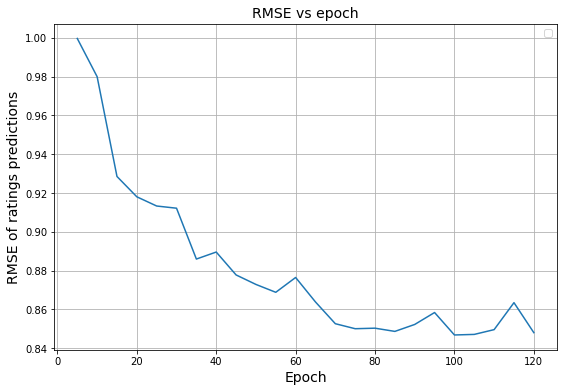

In [28]:
# plot and compare
num_validation_runs = len(history_all32.history["val_root_mean_squared_error"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.figure(figsize=(9,6))
fs = 14
plt.plot(epochs, history_all32.history["val_root_mean_squared_error"])
plt.title("RMSE vs epoch", fontsize=fs)
plt.xlabel("Epoch", fontsize=fs)
plt.ylabel("RMSE of ratings predictions", fontsize=fs);
plt.grid()
plt.legend()
plt.show()